# 第六章 随机近似算法

这一章里的数学推导很多，课本中重点讲解了关于算法的数学原理，收敛原理，以及随机梯度下降中的RM和SGD之间的互推关系。

考虑到时间紧，任务重，只把重点的例子和结论进行记录，数学原理较为直观，不做过多的推导了。

## 1. 引言例子

考虑期望值估计：

$E[X] = \frac{1}{n}\sum_{i=1}^{i=n}x_i$

有两种方法来估计期望值：

1. non-incremental method (非增量方法)

2. incremental method (增量方法)

方法2的更新公式为：
$w_{k+1} = w_k - \frac{1}{k}(w_k-x_k)$

更一般化：

$w_{k+1} = w_k - \alpha_k(w_k-x_k)$

## 2. RM,SGD算法

课本中讲解了两张算法的收敛原理，收敛模式，互相之间的递推关系，这里不做过多的记录，
只将课本中的各个算法：SGD，MBGD的例子用代码实现。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
class PointGenerator:
    """
    生成指定范围内符合均匀分布的二维点，并提供可视化功能
    """
    def __init__(self, num_points=100, x_range=(-10, 10), y_range=(-10, 10)):
        """
        初始化生成器
        :param num_points: 生成点的数量，默认100
        :param x_range: x轴范围，默认(-10, 10)
        :param y_range: y轴范围，默认(-10, 10)
        """
        self.num_points = num_points
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        self.points = None  # 存储生成的点

    def generate_points(self):
        """
        生成符合均匀分布的二维点，并缩放到指定范围
        :return: 生成的点数组，形状为(num_points, 2)
        """
        # 生成均匀分布的随机数（均值0，标准差1）
        x = np.random.rand(self.num_points) * (self.x_max - self.x_min) + self.x_min
        y = np.random.rand(self.num_points) * (self.y_max - self.y_min) + self.y_min

        # 组合成二维点数组
        self.points = np.column_stack((x, y))
        return self.points

    def visualize_points(self, title="均匀分布生成的二维点", save_path=None):
        """
        可视化生成的点
        :param title: 图表标题
        :param save_path: 图片保存路径（可选），如"gaussian_points.png"
        """
        if self.points is None:
            raise ValueError("请先调用generate_points()生成点！")

        # 设置中文字体（避免中文乱码）
        plt.rcParams["font.sans-serif"] = ["SimHei"]
        plt.rcParams["axes.unicode_minus"] = False

        # 创建画布
        plt.figure(figsize=(8, 8))

        # 绘制散点图
        plt.scatter(self.points[:, 0], self.points[:, 1],
                   color='blue', alpha=0.7, s=30, edgecolors='black')

        # 设置坐标轴范围和标签
        plt.xlim(self.x_min - 5, self.x_max + 5)
        plt.ylim(self.y_min - 5, self.y_max + 5)
        plt.xlabel("X 坐标")
        plt.ylabel("Y 坐标")

        # 设置标题和网格
        plt.title(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)

        # 保存图片（如果指定路径）
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        # 显示图表
        plt.show()

生成了 100 个点，前5个点：
[[-7.07894711  8.68949528]
 [ 9.69121061 -8.09375591]
 [-8.65507998 -1.30062968]
 [ 5.65630692 -7.90273671]
 [-5.66205765 -8.61031146]]


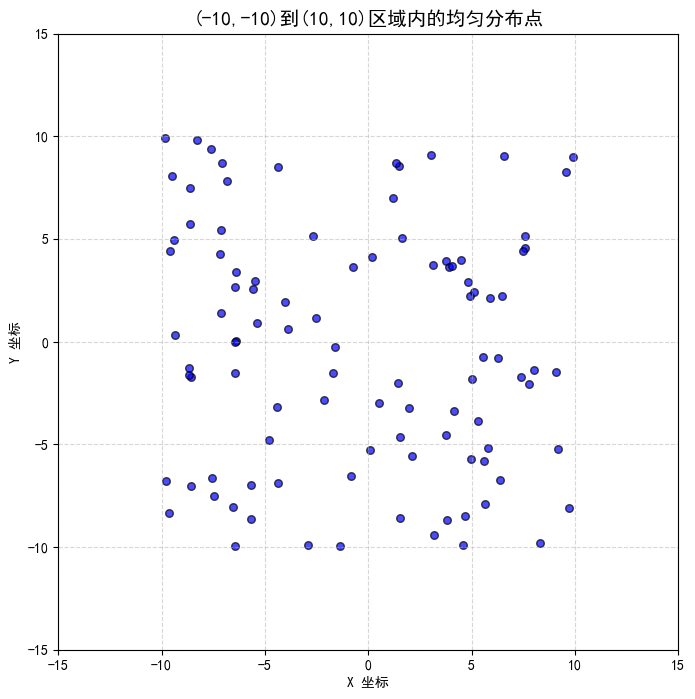

In [3]:
# 创建生成器实例
generator = PointGenerator(num_points=100)

# 生成点
points = generator.generate_points()
print(f"生成了 {len(points)} 个点，前5个点：")
print(points[:5])

# 可视化点
generator.visualize_points(title="(-10,-10)到(10,10)区域内的均匀分布点")
# 如果需要保存图片，取消下面注释
# generator.visualize_points(save_path="gaussian_points.png")

暂停，先捋一下sgd算法的流程：

首先，我们是在估计一个点集的均值，假设这个点集是从某个分布中采样得到的，我们用w来表示均值的估计。

第二，我们有一个损失函数，表示当前估计的均值和实际采样点之间的差距：

$L(w, x) = (x - w)^2$

而且，我们的目标是最小化目标函数：

$J(w)=\frac{1}{n}\sum_{i=1}^n L(w,x_i)$

In [4]:
class SGDMeanEstimator:
    """
    随机梯度下降(SGD)算法类，用于估计二维点集的均值
    """
    def __init__(self, points, lr=0.01, epochs=5, seed=42):
        """
        初始化SGD估计器
        :param points: 二维点集数组，形状为(n, 2)
        :param lr: 学习率，默认0.01，这里用lr/k来做学习率，可以据情况调整
        :param epochs: 迭代轮数（每轮遍历所有点），默认5
        :param seed: 随机种子，保证结果可复现
        """
        self.points = points  # 输入的点集
        self.lr = lr  # 学习率
        self.epochs = epochs  # 迭代轮数
        self.seed = seed  # 随机种子

        self.mean_estimate = None  # 当前均值估计值
        self.sgd_path = []  # 存储SGD迭代路径
        self.final_mean = None  # 最终估计的均值

    def _compute_gradient(self, single_point):
        """
        计算单个样本的梯度（损失函数：均方误差MSE）
        MSE = (mean - point)^2，梯度为 2*(mean - point)
        :param single_point: 单个二维点，形状为(2,)
        :return: 梯度，形状为(2,)
        """
        return 2 * (self.mean_estimate - single_point)

    def fit(self):
        """执行SGD迭代，估计均值并记录路径"""
        np.random.seed(self.seed)

        # 随机初始化均值估计值（不一定在点集范围内）
        x_min, x_max = np.min(self.points[:, 0]) * 2, np.max(self.points[:, 0]) * 2
        y_min, y_max = np.min(self.points[:, 1]) * 2, np.max(self.points[:, 1]) * 2
        self.mean_estimate = np.array([
            np.random.uniform(x_min, x_max),
            np.random.uniform(y_min, y_max)
        ])
        self.sgd_path = [self.mean_estimate.copy()]  # 记录初始值

        # SGD核心迭代逻辑
        for epoch in range(self.epochs):
            # 每轮打乱点的顺序（SGD的随机性核心）
            shuffled_indices = np.random.permutation(len(self.points))

            for idx in shuffled_indices:
                point = self.points[idx]
                # 计算梯度
                gradient = self._compute_gradient(point)
                # 梯度下降更新均值估计
                self.mean_estimate -= self.lr/(epoch+1) * gradient
            self.sgd_path.append(self.mean_estimate.copy())


        # 转换为数组，方便后续可视化
        self.sgd_path = np.array(self.sgd_path)
        self.final_mean = self.mean_estimate.copy()
        return self.final_mean

    def visualize_sgd_path(self, true_mean, title="SGD估计均值的迭代路径", save_path=None):
        """
        可视化SGD迭代路径、原始点集、真实均值和估计均值
        :param true_mean: 点集的真实均值，形状为(2,)
        :param title: 图表标题
        :param save_path: 图片保存路径（可选）
        """
        if len(self.sgd_path) == 0:
            raise ValueError("请先调用fit()执行SGD迭代！")

        # 设置中文字体，避免乱码
        plt.rcParams["font.sans-serif"] = ["SimHei"]
        plt.rcParams["axes.unicode_minus"] = False

        # 创建画布
        plt.figure(figsize=(10, 10))

        # 1. 绘制原始点集
        plt.scatter(
            self.points[:, 0], self.points[:, 1],
            color='lightblue', alpha=0.6, s=30, edgecolors='black',
            label='原始均匀分布点'
        )

        # 2. 绘制SGD迭代路径
        plt.plot(
            self.sgd_path[:, 0], self.sgd_path[:, 1],
            color='red', linewidth=2, alpha=0.8,
            label='SGD迭代路径'
        )

        # 3. 标记关键节点：起点、最终估计值、真实均值
        plt.scatter(self.sgd_path[0, 0], self.sgd_path[0, 1],
                   color='orange', s=120, marker='*', label='SGD起点')
        plt.scatter(self.final_mean[0], self.final_mean[1],
                   color='green', s=120, marker='*', label='SGD估计均值')
        plt.scatter(true_mean[0], true_mean[1],
                   color='purple', s=120, marker='o', facecolors='none',
                   linewidth=3, label='真实均值')

        # 设置坐标轴和标签
        x_margin = (np.max(self.points[:, 0]) - np.min(self.points[:, 0])) * 0.5
        y_margin = (np.max(self.points[:, 1]) - np.min(self.points[:, 1])) * 0.5
        plt.xlim(np.min(self.points[:, 0]) - x_margin, np.max(self.points[:, 0]) + x_margin)
        plt.ylim(np.min(self.points[:, 1]) - y_margin, np.max(self.points[:, 1]) + y_margin)
        plt.xlabel("X 坐标", fontsize=12)
        plt.ylabel("Y 坐标", fontsize=12)

        # 设置标题、网格、图例
        plt.title(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='best', fontsize=10)

        # 保存图片（可选）
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        # 显示图表
        plt.show()

SGD估计的均值：x=-0.5506, y=-0.2887


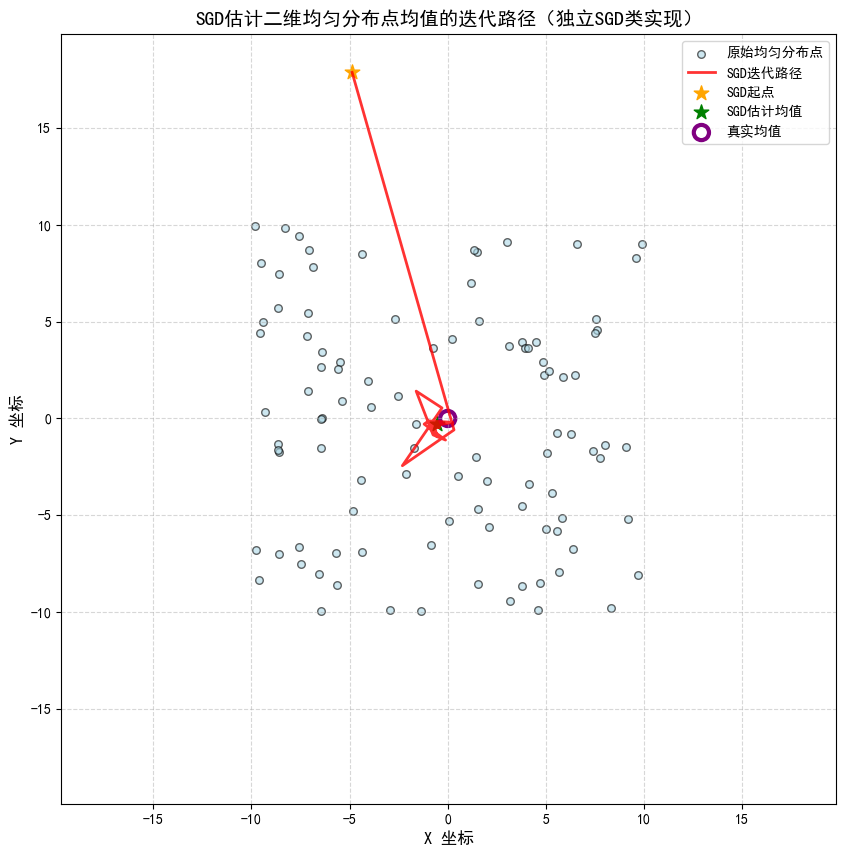

In [5]:
sgd_estimator = SGDMeanEstimator(points=points, lr=0.1, epochs=50)
estimated_mean = sgd_estimator.fit()
print(f"SGD估计的均值：x={estimated_mean[0]:.4f}, y={estimated_mean[1]:.4f}")

# 步骤3：可视化SGD迭代路径
sgd_estimator.visualize_sgd_path(
    true_mean=(0,0),
    title="SGD估计二维均匀分布点均值的迭代路径（独立SGD类实现）"
    # save_path="sgd_mean_estimate_path.png"  # 如需保存图片，取消注释
)

MBGD的实现和SGD类似，只不过每次是用一个小批量的数据来计算梯度。

In [10]:
class MBGDMeanEstimator:
    """
    小批量随机梯度下降(MBGD)算法类，用于估计二维点集的均值
    """
    def __init__(self, points, lr=0.01, epochs=5, batch_size=10, seed=42):
        """
        初始化MBGD估计器
        :param points: 二维点集数组，形状为(n, 2)
        :param lr: 学习率，默认0.01，这里用lr/k来做学习率，可以据情况调整
        :param epochs: 迭代轮数（每轮遍历所有点），默认5
        :param batch_size: 小批量大小，默认10
        :param seed: 随机种子，保证结果可复现
        """
        self.points = points  # 输入的点集
        self.lr = lr  # 学习率
        self.epochs = epochs  # 迭代轮数
        self.batch_size = batch_size  # 小批量大小
        self.seed = seed  # 随机种子

        self.mean_estimate = None  # 当前均值估计值
        self.mbgd_path = []  # 存储MBGD迭代路径
        self.final_mean = None  # 最终估计的均值

    def _compute_batch_gradient(self, batch_points):
        """
        计算小批量样本的梯度（损失函数：均方误差MSE）
        MSE = (mean - point)^2，梯度为 2*(mean - point)
        :param batch_points: 小批量二维点，形状为(batch_size, 2)
        :return: 平均梯度，形状为(2,)
        """
        gradients = 2 * (self.mean_estimate - batch_points)
        return np.mean(gradients, axis=0)

    def fit(self):
        """执行MBGD迭代，估计均值并记录路径"""
        np.random.seed(self.seed)

        # 随机初始化均值估计值（在点集范围内）
        x_min, x_max = np.min(self.points[:, 0]) * 2, np.max(self.points[:, 0] * 2)
        y_min, y_max = np.min(self.points[:, 1]) * 2, np.max(self.points[:, 1] * 2)
        self.mean_estimate = np.array([
            np.random.uniform(x_min, x_max),
            np.random.uniform(y_min, y_max)
        ])
        self.mbgd_path = [self.mean_estimate.copy()]  # 记录初始值
        num_points = len(self.points)
        # MBGD核心迭代逻辑
        for epoch in range(self.epochs):
            # 每轮打乱点的顺序（MBGD的随机性核心）
            shuffled_indices = np.random.permutation(num_points)

            for start_idx in range(0, num_points, self.batch_size):
                end_idx = min(start_idx + self.batch_size, num_points)
                batch_indices = shuffled_indices[start_idx:end_idx]
                batch_points = self.points[batch_indices]

                # 计算小批量梯度
                batch_gradient = self._compute_batch_gradient(batch_points)
                # 梯度下降更新均值估计
                self.mean_estimate -= self.lr/((self.epochs + 1) * self.batch_size) * batch_gradient
            self.mbgd_path.append(self.mean_estimate.copy())
        # 转换为数组，方便后续可视化
        self.mbgd_path = np.array(self.mbgd_path)
        self.final_mean = self.mean_estimate.copy()
        return self.final_mean

    def visualize_mbgd_path(self, true_mean, title="MBGD估计均值的迭代路径", save_path=None):
        """
        可视化MBGD迭代路径、原始点集、真实均值和估计均值
        :param true_mean: 点集的真实均值，形状为(2,)
        :param title: 图表标题
        :param save_path: 图片保存路径（可选）
        """
        if len(self.mbgd_path) == 0:
            raise ValueError("请先调用fit()执行MBGD迭代！")
        # 设置中文字体，避免乱码
        plt.rcParams["font.sans-serif"] = ["SimHei"]
        plt.rcParams["axes.unicode_minus"] = False
        # 创建画布
        plt.figure(figsize=(10, 10))
        # 1. 绘制原始点集
        plt.scatter(
            self.points[:, 0], self.points[:, 1],
            color='lightblue', alpha=0.6, s=30, edgecolors='black',
            label='原始均匀分布点'
        )
        # 2. 绘制MBGD迭代路径
        plt.plot(
            self.mbgd_path[:, 0], self.mbgd_path[:, 1],
            color='red', linewidth=2, alpha=0.8,
            label='MBGD迭代路径'
        )
        # 3. 标记关键节点：起点、最终估计值、真实均值
        plt.scatter(self.mbgd_path[0, 0], self.mbgd_path[0, 1],
                   color='orange', s=120, marker='*', label='MBGD起点')
        plt.scatter(self.final_mean[0], self.final_mean[1],
                     color='green', s=120, marker='*', label='MBGD估计均值')
        plt.scatter(true_mean[0], true_mean[1],
                     color='purple', s=120, marker='o', facecolors='none',
                     linewidth=3, label='真实均值')
        # 设置坐标轴和标签
        x_margin = (np.max(self.points[:, 0]) - np.min(self.points[:, 0])) * 0.5
        y_margin = (np.max(self.points[:, 1]) - np.min(self.points[:, 1])) * 0.5
        plt.xlim(np.min(self.points[:, 0]) - x_margin, np.max(self.points[:, 0]) + x_margin)
        plt.ylim(np.min(self.points[:, 1]) - y_margin, np.max(self.points[:, 1]) + y_margin)
        plt.xlabel("X 坐标", fontsize=12)
        plt.ylabel("Y 坐标", fontsize=12)
        # 设置标题、网格、图例
        plt.title(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='best', fontsize=10)
        # 保存图片（可选）
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        # 显示图表
        plt.show()

MBGD估计的均值：x=-0.5499, y=-0.2899


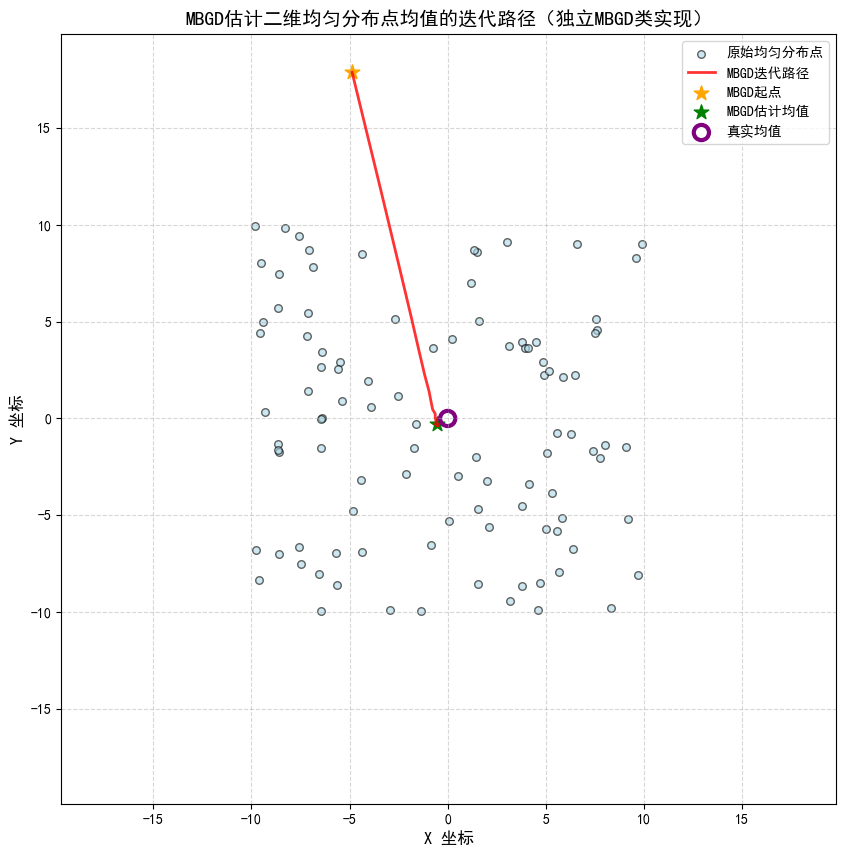

In [11]:
mbgd_estimator = MBGDMeanEstimator(
    points=points, lr=0.1, epochs=50, batch_size=1)
estimated_mean_mbgd = mbgd_estimator.fit()
print(
    f"MBGD估计的均值：x={estimated_mean_mbgd[0]:.4f}, y={estimated_mean_mbgd[1]:.4f}")
mbgd_estimator.visualize_mbgd_path(
    true_mean=(0, 0),
    title="MBGD估计二维均匀分布点均值的迭代路径（独立MBGD类实现）"
    # save_path="mbgd_mean_estimate_path.png"  # 如需保存图片，取消注释
)

MBGD估计的均值：x=-1.1373, y=2.2322


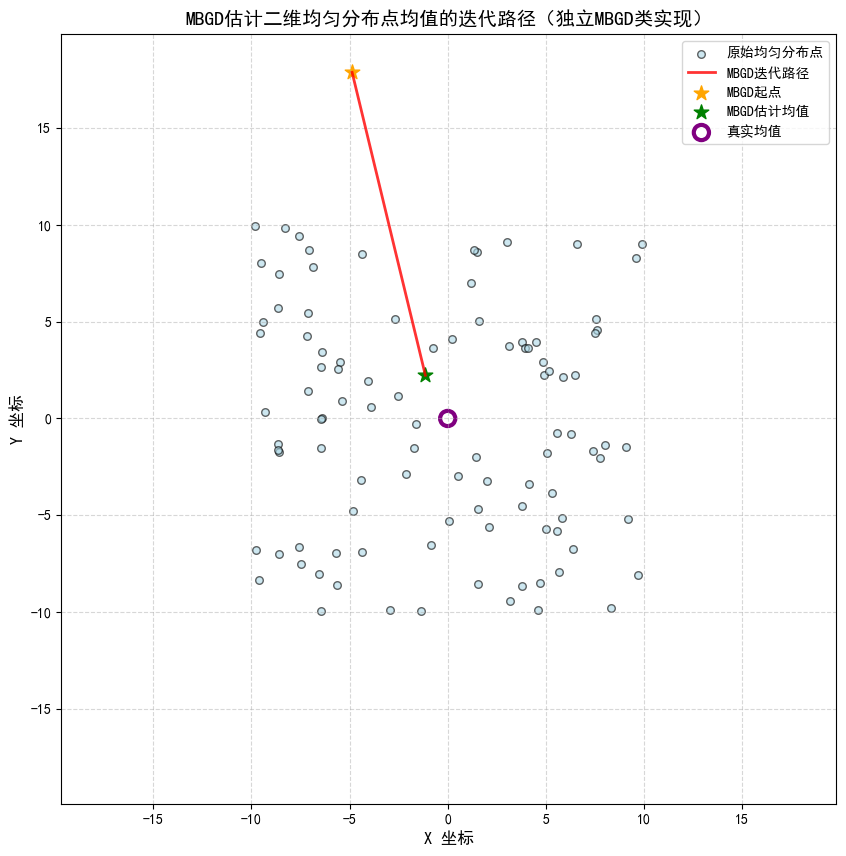

In [12]:
mbgd_estimator = MBGDMeanEstimator(points=points, lr=1, epochs=50, batch_size=10)
estimated_mean_mbgd = mbgd_estimator.fit()
print(f"MBGD估计的均值：x={estimated_mean_mbgd[0]:.4f}, y={estimated_mean_mbgd[1]:.4f}")
mbgd_estimator.visualize_mbgd_path(
    true_mean=(0, 0),
    title="MBGD估计二维均匀分布点均值的迭代路径（独立MBGD类实现）"
    # save_path="mbgd_mean_estimate_path.png"  # 如需保存图片，取消注释
)

MBGD估计的均值：x=-4.0937, y=14.6275


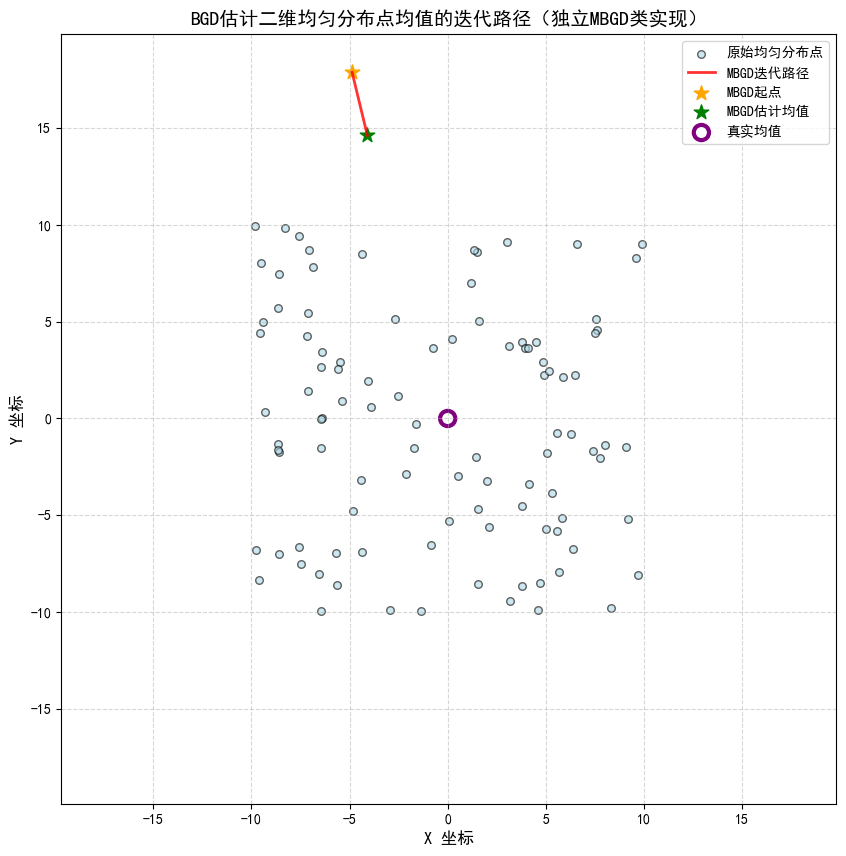

In [13]:
mbgd_estimator_bigger = MBGDMeanEstimator(points=points, lr=10, epochs=50, batch_size=100)
estimated_mean_mbgd = mbgd_estimator_bigger.fit()
print(f"MBGD估计的均值：x={estimated_mean_mbgd[0]:.4f}, y={estimated_mean_mbgd[1]:.4f}")
mbgd_estimator_bigger.visualize_mbgd_path(
    true_mean=(0, 0),
    title="BGD估计二维均匀分布点均值的迭代路径（独立MBGD类实现）"
    # save_path="mbgd_mean_estimate_path.png"  # 如需保存图片，取消注释
)